# Ejercicio de Feedback Matemáticas y Estadística para la IA

## Enunciado
Eres un analista de datos contratado para explorar y extraer insights del dataset "International Football Results from 1872 to 2024", disponible en Kaggle https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to2017/data.
Este dataset contiene información sobre más de 47,000 partidos internacionales de fútbol masculino, desde el primer partido oficial en 1872 hasta la actualidad, incluyendo datos de torneos históricos como la Copa Mundial de la FIFA y partidos amistosos. Tu tarea es analizar este conjunto de datos utilizando las técnicas y herramientas aprendidas a lo largo del curso: estadística descriptiva, análisis EDA, modelos de clasificación y decisión, estimación bayesiana, depuración e imputación de datos, y redes neuronales avanzadas. Además, deberás responder preguntas clave sobre el impacto de jugar en casa, tendencias históricas, y los factores que influyen en los resultados. Este análisis se realizará de manera individual y se entregará como un informe final.

## Exploración Inicial y Análisis Descriptivo

### Exploración Inicial, EDA y Limpieza de Datos (1 puntos)

- Carga y explora el archivo results.csv:
    - Identifica las variables disponibles, tipos de datos y posibles errores (valores nulos, nombres duplicados).
    - Realiza una limpieza básica de los datos, incluyendo corrección de inconsistencias.
    - Implementa métodos de imputación para manejar datos faltantes.
        - Variables categóricas: imputación por moda.
        - Variables númericas: media, mediana o interpolación.

Cargaremos el dataset usando la libreria `kagglehub` para simplificar el proceso

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("martj42/international-football-results-from-1872-to-2017")

In [23]:
import pandas as pd
results_df = pd.read_csv(path + "/results.csv")

Una vez descargado y cargado el dataset en un dataframe, pasamos a ver de manera resumida como es el dataset.

In [24]:
# Obtenemos los primeros 5 registros
results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [25]:
# Obtenemos las columnas numericas y algunas metrícas básicas
results_df.describe()


,home_score,away_score
count,47917.000000,47917.000000
mean,1.757873,1.181752
std,1.772538,1.399573
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


In [26]:
#Obtenemos las columnas categoricas y algunas metrícas básicas
results_df.describe(include=['object'])

,date,home_team,away_team,tournament,city,country
count,47917,47917,47917,47917,47917,47917
unique,16228,327,321,176,2080,270
top,2012-02-29,Brazil,Uruguay,Friendly,Kuala Lumpur,United States
freq,66,605,575,18040,730,1407


In [27]:
# Obtenemos los valores nulos o faltantes
results_df.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Podemos ver como no existen valores faltantes entre los datos. Aún así, con proposito demostrativo, veremos como hacer la imputacion de datos en variables categoricas y numéricas

In [28]:
# Imputación por moda de todas las columnas categoricas
for column in results_df.select_dtypes(include=['object']).columns:
    results_df[column].fillna(results_df[column].mode()[0], inplace=True)

In [29]:
# Imputación por media de todas las columnas numericas
for column in results_df.select_dtypes(include=['float64', 'int64']).columns:
    results_df[column].fillna(results_df[column].mean(), inplace=True)

- Exploración incial EDA:
    - Identifica distribuciones principales (histogramas, boxplots, etc).
    - Analiza correlaciones iniciales entre variables cuantitativas (matriz de correlación).
    - Si fuese necesario, crea variables derivadas, como, por ejemplo: diferencia de goles, década del partido, etc.
        - Analiza relaciones categóricas, como frecuencia de victorias locales o torneos más populares, utilizando gráficos de barras y/o mapas de calor.

In [30]:
import matplotlib.pyplot as plt

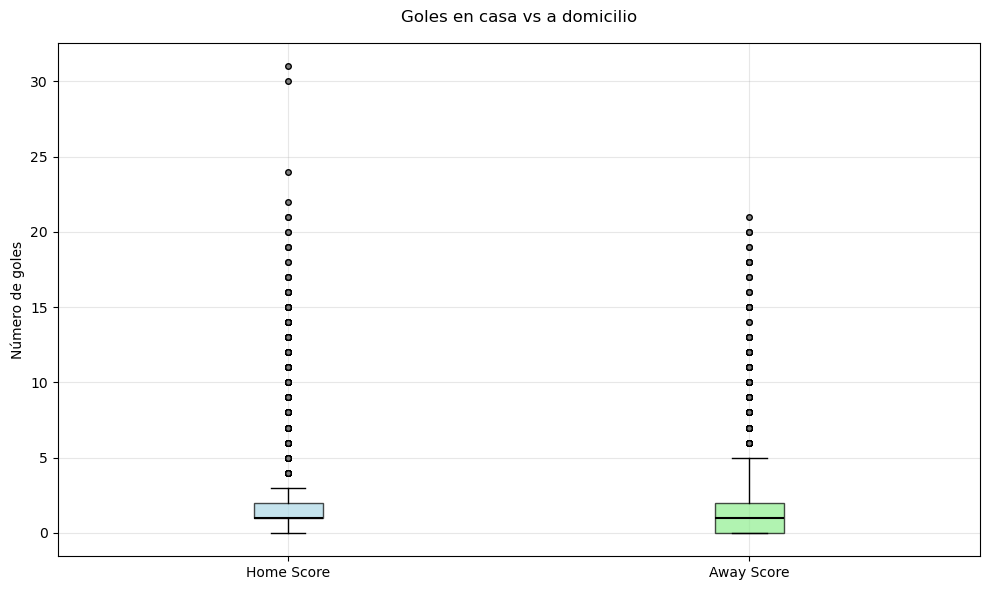

In [31]:
plt.figure(figsize=(10, 6))
box = plt.boxplot([results_df['home_score'], results_df['away_score']], 
                  labels=['Home Score', 'Away Score'],
                  patch_artist=True,
                  medianprops=dict(color="black", linewidth=1.5),
                  flierprops=dict(marker='o', markerfacecolor='gray', markersize=4))

# Set colors for boxes
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Goles en casa vs a domicilio', pad=15)
plt.ylabel('Número de goles')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

Ahora haremos el análisis de correlaciones

In [32]:
#Obtenemos la matriz de correlación
results_df_numeric = results_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = results_df_numeric.corr()
correlation_matrix

,home_score,away_score
home_score,1.000000,-0.143857
away_score,-0.143857,1.000000


Ya hemos creado algunas variables derivadas como decada o total de goles. Añadiremos alguna mas como quien gana, si el equipo local o visitante, o el empate en caso de que fuera necesario. Tambien podemos añadir los dias de descanso antes de los partidos para analizar como influye en el resultado.

In [33]:
results_df['result'] = results_df['home_score'] - results_df['away_score']
results_df['result'] = results_df['result'].apply(lambda x: 'home' if x > 0 else 'draw' if x == 0 else 'away')

In [34]:
# Procesamos la fecha para poder operar con ella
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['rest_days_home'] = results_df.groupby('home_team')['date'].diff().dt.days
results_df['rest_days_away'] = results_df.groupby('away_team')['date'].diff().dt.days

In [35]:
# Comprobamos si existen valores nulos
results_df[['rest_days_home', 'rest_days_away', 'result']].isnull().sum()

rest_days_home    327
rest_days_away    321
result              0
dtype: int64

In [36]:
#Imputamos 0 días de descanso para esos casos
results_df.fillna(0, inplace=True)

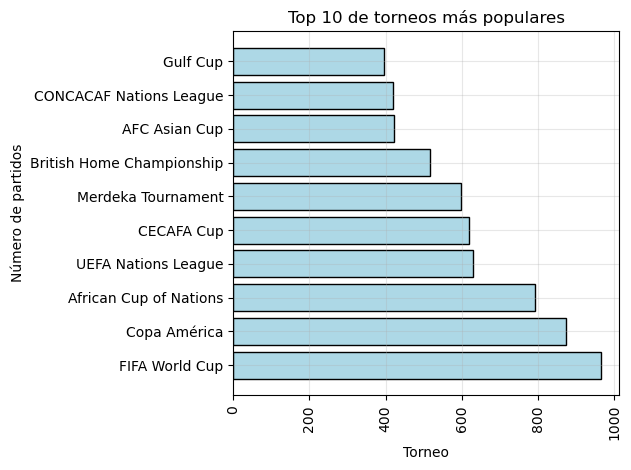

In [37]:
# Top 10 de torneos más populares sin contar amistosos y clasificatorias
top_10_tournaments = results_df['tournament'].loc[~results_df['tournament'].str.contains('Friendly|qualification')].value_counts().head(10)
plt.barh(top_10_tournaments.index, top_10_tournaments.values, color='lightblue', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Top 10 de torneos más populares')
plt.xlabel('Torneo')
plt.ylabel('Número de partidos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

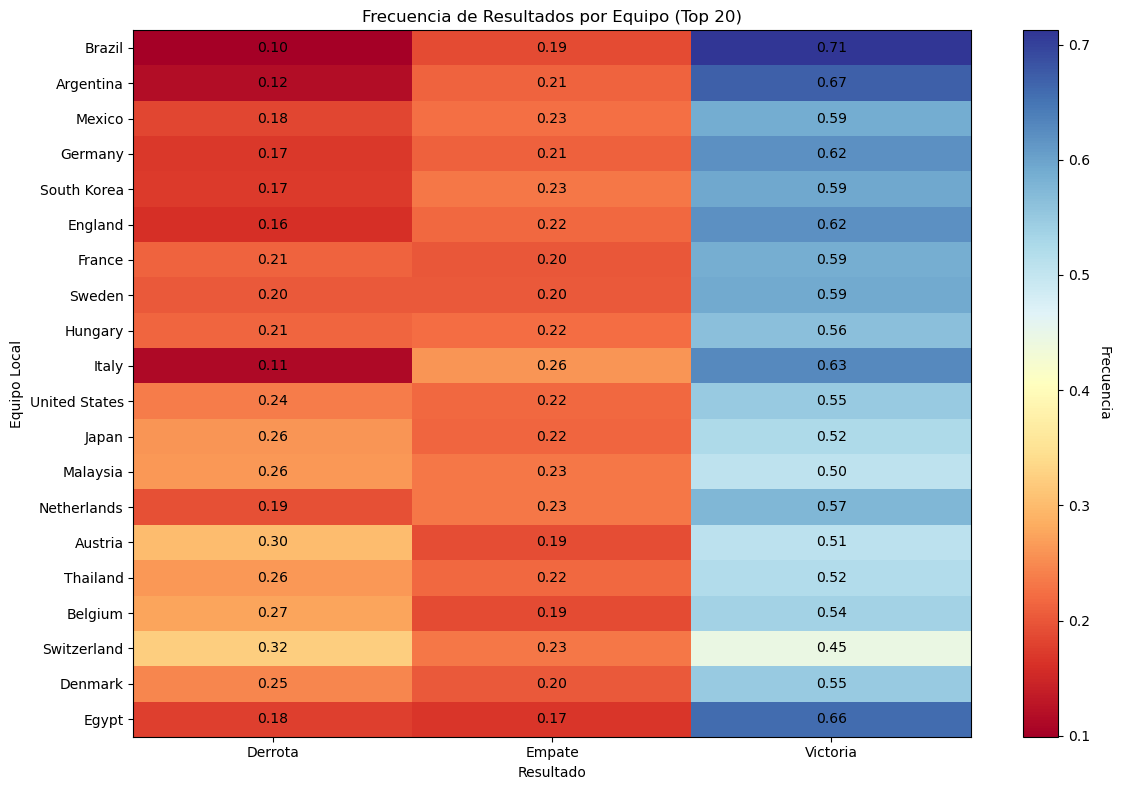

In [38]:

result_cross = pd.crosstab(results_df['home_team'], results_df['result'])
result_cross = result_cross.div(result_cross.sum(axis=1), axis=0)

# Para visualizar mejor los datos, usaremos los 20 equipos que más partidos han jugado
top_teams = results_df['home_team'].value_counts().head(20).index
result_cross_filtered = result_cross.loc[top_teams]

plt.figure(figsize=(12, 8))
plt.imshow(result_cross_filtered, cmap='RdYlBu', aspect='auto')
plt.title('Frecuencia de Resultados por Equipo (Top 20)')
plt.xlabel('Resultado')
plt.ylabel('Equipo Local')
plt.yticks(range(len(top_teams)), top_teams)
plt.xticks(range(3), ['Derrota', 'Empate', 'Victoria'])

cbar = plt.colorbar(label='Frecuencia')
cbar.ax.set_ylabel('Frecuencia', rotation=270, labelpad=15)

for i in range(len(top_teams)):
    for j in range(3):
        plt.text(j, i, f'{result_cross_filtered.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## Análisis Descriptivo Avanzado y EDA

- Responde preguntas clave utilizando análisis estadístico descriptivo:
    - ¿Cuál es la media de goles anotados por partido?
    - ¿Cuántos partidos se jugaron por década y en qué torneos?
    - ¿Qué equipos tienen el mayor rendimiento histórico jugando como
local?

In [39]:
#Media de goles por partido
results_df['total_goals'] = results_df['home_score'] + results_df['away_score']
results_df['total_goals'].mean()

2.939624767827702

In [41]:
# Partidos jugados en cada decada
results_df['decade'] = results_df['date'].dt.year // 10 * 10
decade_counts = results_df['decade'].value_counts().sort_index()
decade_counts

decade
1870      13
1880      55
1890      59
1900     134
1910     304
1920     814
1930    1083
1940     832
1950    1649
1960    2983
1970    4131
1980    5026
1990    6948
2000    9525
2010    9752
2020    4609
Name: count, dtype: int64

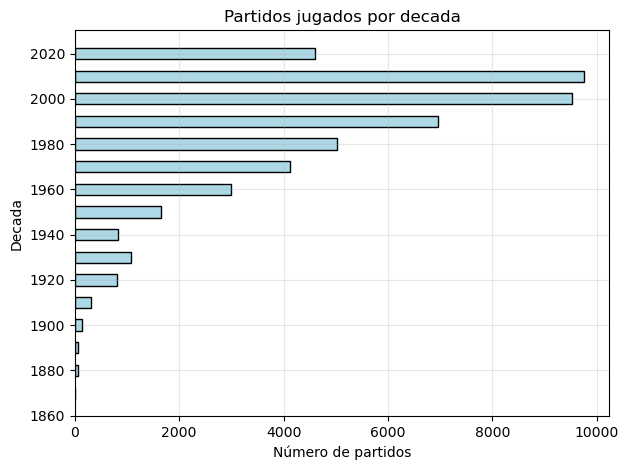

In [42]:
#Histograma de los partidos jugados por decada
plt.barh(
    results_df['decade'].value_counts().sort_index().index,
    results_df['decade'].value_counts().sort_index().values,
    color='lightblue',
    edgecolor='black',
    height=5)
plt.title('Partidos jugados por decada')
plt.xlabel('Número de partidos')
plt.ylabel('Decada')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

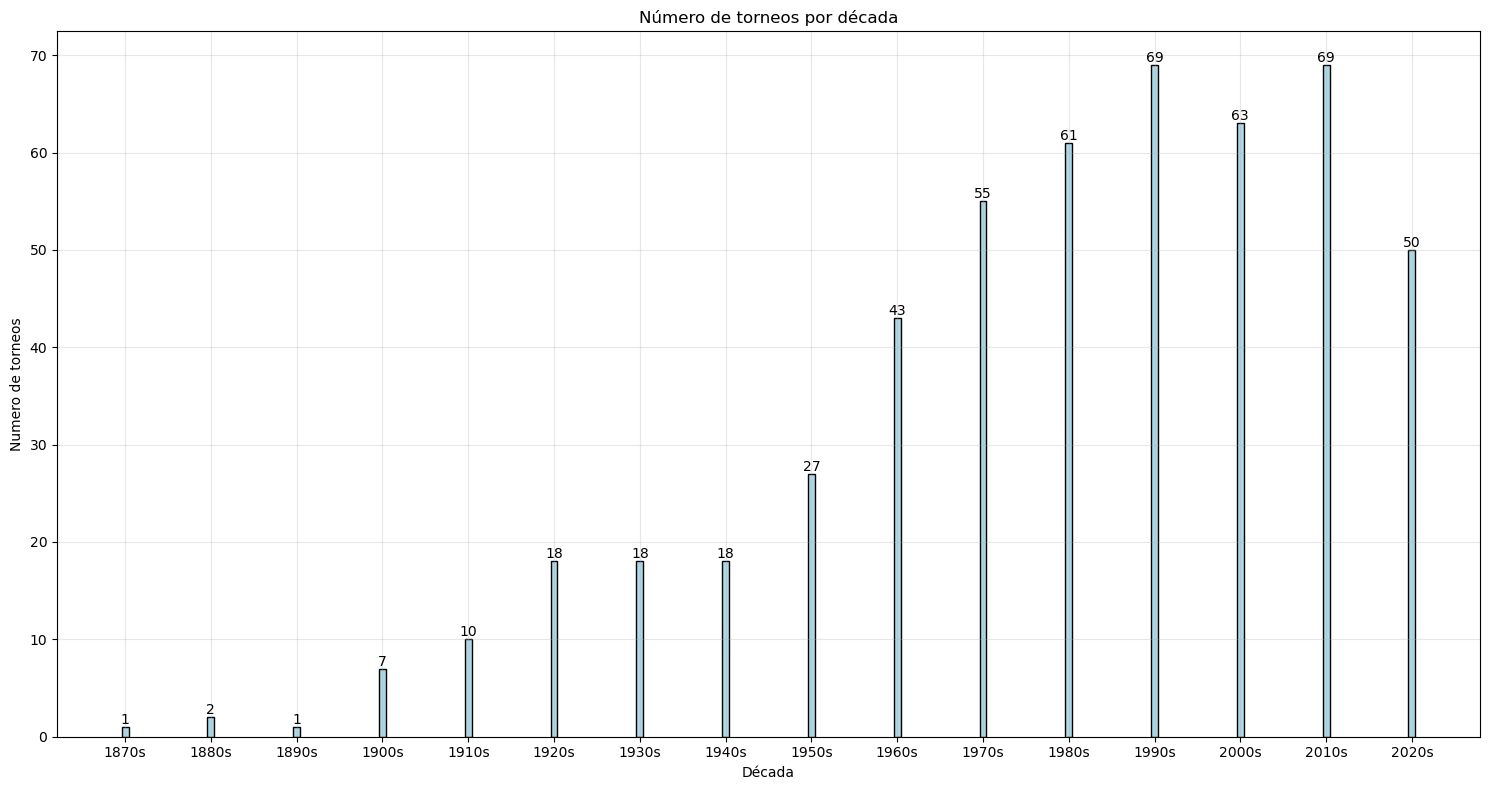

Década 1870:
Friendly
Década 1880:
British Home Championship, Friendly
Década 1890:
British Home Championship
Década 1900:
British Home Championship, Copa Lipton, Copa Newton, Copa Premio Honor Argentino, Friendly, Muratti Vase, Évence Coppée Trophy
Década 1910:
British Home Championship, Copa América, Copa Lipton, Copa Newton, Copa Premio Honor Argentino, Copa Premio Honor Uruguayo, Copa Roca, Far Eastern Championship Games, Friendly, Muratti Vase
Década 1920:
Balkan Cup, Baltic Cup, British Home Championship, Central European International Cup, Copa América, Copa Chevallier Boutell, Copa Lipton, Copa Newton, Copa Premio Honor Argentino, Copa Premio Honor Uruguayo, Copa Roca, Far Eastern Championship Games, Friendly, Muratti Vase, Nordic Championship, Olympic Games, Open International Championship, Peace Cup
Década 1930:
Balkan Cup, Baltic Cup, Bolivarian Games, British Home Championship, Central American and Caribbean Games, Central European International Cup, Copa América, Copa Chev

In [54]:
tournament_decade = results_df.groupby('decade')['tournament'].nunique()

plt.figure(figsize=(15, 8))
plt.bar(tournament_decade.index, tournament_decade.values, color='lightblue', edgecolor='black')
plt.title('Número de torneos por década')
plt.xlabel('Década')
plt.ylabel('Numero de torneos')
plt.grid(True, alpha=0.3)
plt.xticks(ticks=tournament_decade.index, labels=[f"{str(decade)}s" for decade in tournament_decade.index])

for i, v in enumerate(tournament_decade.values):
    plt.text(tournament_decade.index[i], v, str(v), 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

for decade in sorted(tournament_decade.index):
    tournaments = results_df[results_df['decade'] == decade]['tournament'].unique()
    print(f"Década {decade}:")
    print(', '.join(sorted(tournaments)))

In [58]:
#Mejor equipo jugando en casa
home_team_results = results_df.groupby('home_team')['result'].value_counts().unstack().fillna(0)
home_team_results['total'] = home_team_results.sum(axis=1)
home_team_results['win_rate'] = home_team_results['home'] / home_team_results['total']
home_team_results['win_rate'].sort_values(ascending=False).head(10)

home_team
Chameria              1.0
Elba Island           1.0
Parishes of Jersey    1.0
Franconia             1.0
Hmong                 1.0
Cascadia              1.0
Central Spain         1.0
Luhansk PR            1.0
Western Australia     1.0
Yorkshire             0.8
Name: win_rate, dtype: float64

In [62]:
# Ahora teniendo en cuenta los que tengan un minumo de 100 partidos jugados
home_team_results_min_100_matches = home_team_results[home_team_results['total'] >= 100]
home_team_results_min_100_matches['win_rate'] = home_team_results_min_100_matches['home'] / home_team_results_min_100_matches['total']
home_team_results_min_100_matches['win_rate'].sort_values(ascending=False).head(10)

home_team
Brazil            0.712397
Jersey            0.700787
Spain             0.687657
Argentina         0.670588
Czech Republic    0.660819
Guernsey          0.659091
Egypt             0.657407
Ivory Coast       0.648562
Iran              0.641176
New Caledonia     0.627586
Name: win_rate, dtype: float64